In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt

In [2]:
# Define paths
dataset_dir = r"E:\ML EXTENSION\Archive_2"  # replace with the path to your dataset directory

In [3]:
# Image data generators with validation split
datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    validation_split=0.25,  # 25% for validation/testing
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [4]:
# Training generator
train_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=(224, 224),  # EfficientNetB0 input size
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

Found 9750 images belonging to 13 classes.


In [5]:
# Validation generator
val_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=(224, 224),  # EfficientNetB0 input size
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

Found 3250 images belonging to 13 classes.


In [6]:
# Load the EfficientNetB0 model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [7]:
# Freeze the layers of EfficientNetB0 model
for layer in base_model.layers:
    layer.trainable = False

In [8]:
# Feature extraction
x = Flatten()(base_model.output)

In [9]:
# Define the model building function for Keras Tuner
def build_model(hp):
    model = tf.keras.Sequential()
    model.add(base_model)
    model.add(Flatten())
    
    # Tune the number of units in the Dense layers
    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(Dense(units=hp.Int('units_' + str(i), min_value=128, max_value=512, step=64),
                        activation='relu'))
        model.add(Dropout(rate=hp.Float('dropout_' + str(i), min_value=0.2, max_value=0.5, step=0.1)))

    model.add(Dense(13, activation='softmax'))  # 13 classes

    # Tune the learning rate for the optimizer
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [10]:
# Instantiate the tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=12,
    executions_per_trial=1,
    directory='tuner_dir',
    project_name='image_classification'
)

Reloading Tuner from tuner_dir\image_classification\tuner0.json


In [11]:
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [12]:
# Search for the best hyperparameters
tuner.search(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=50,  # max epochs
    callbacks=[early_stopping]
)

Trial 12 Complete [00h 31m 56s]
val_accuracy: 0.1666666716337204

Best val_accuracy So Far: 0.1666666716337204
Total elapsed time: 15h 14m 42s


In [15]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [16]:
# Build the best model
model = tuner.hypermodel.build(best_hps)

In [17]:
# Train the model with the optimal hyperparameters
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=50,  # you can adjust the number of epochs
    callbacks=[early_stopping]
)

Epoch 1/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 626s 2s/step - accuracy: 0.0790 - loss: 4.2492 - val_accuracy: 0.0767 - val_loss: 2.5650
Epoch 2/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0625 - loss: 2.5649 - val_accuracy: 0.1111 - val_loss: 2.5646
Epoch 3/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 543s 2s/step - accuracy: 0.0719 - loss: 2.5779 - val_accuracy: 0.0767 - val_loss: 2.5650
Epoch 4/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0000e+00 - loss: 2.5665 - val_accuracy: 0.1111 - val_loss: 2.5662
Epoch 5/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 496s 2s/step - accuracy: 0.0746 - loss: 2.5677 - val_accuracy: 0.0770 - val_loss: 2.5650
Epoch 6/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.0312 - loss: 2.5655 - val_accuracy: 0.0556 - val_loss: 2.5658
Epoch 7/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 494s 2s/step - accuracy: 0.0750 - loss: 2.5651 - val_accuracy: 0.0770 - val_loss: 2.5650


In [18]:
# Get the final training accuracy
final_training_accuracy = history.history['accuracy'][-1]
print(f'Final Training Accuracy: {final_training_accuracy * 100:.2f}%')

Final Training Accuracy: 7.17%


In [19]:
# You can also get the final validation accuracy
final_validation_accuracy = history.history['val_accuracy'][-1]
print(f'Final Validation Accuracy: {final_validation_accuracy * 100:.2f}%')

Final Validation Accuracy: 7.70%


In [20]:
# Evaluate the model on the test set
test_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=(224, 224),  # EfficientNetB0 input size
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 3250 images belonging to 13 classes.


In [21]:
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
print(f'Test Loss: {test_loss:.4f}')

101/101 ━━━━━━━━━━━━━━━━━━━━ 83s 815ms/step - accuracy: 0.0248 - loss: 2.5657
Test Accuracy: 7.74%
Test Loss: 2.5650


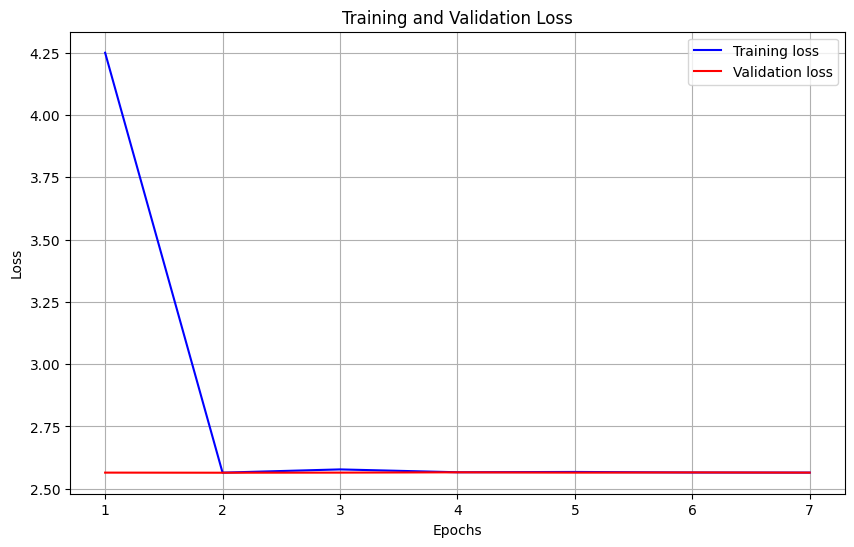

In [2]:
import matplotlib.pyplot as plt

# Example data (replace with your actual data)
epochs = range(1, 8)  # epochs from 1 to 7 as per the provided data
train_loss = [4.2492, 2.5649, 2.5779, 2.5665, 2.5677, 2.5655, 2.5651]  # training loss values
val_loss = [2.5650, 2.5646, 2.5650, 2.5662, 2.5650, 2.5658, 2.5650]  # validation loss values

# Plotting the loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
